# Named Entity Recognition with BERT
https://medium.com/@acsariyildiz/named-entity-recognition-with-bert-in-10-steps-6511d4c60d74


https://towardsdatascience.com/named-entity-recognition-with-deep-learning-bert-the-essential-guide-274c6965e2d (accessable via https://archive.is/55ieC)


* CONLL2003 is a dataset for fine-tuning the model.
* A Python Notebook In Google Colab (Enabled with GPU)

The training process involves the following steps:

1. Load the Libraries
2. Inspect the Dataset
3. Verify the Alignment
4. Tokenize the Dataset
5. Configure the Data Collator
6. Set up the Metric Calculation
7. Initialize the Model
8. Define the Training Arguments
9. Begin Training
10. Evaluate the Results


## Step 1 : Load The Libraries

In [1]:
#Import needed libraries
#The guide I used didn't specify versions, but I know the latest libraries don't work. So we need to use these.
!pip install transformers datasets tokenizers seqeval -q
!pip install tensorflow-probability==0.23.0
!pip install seqeval -U
!pip install evaluate==0.4.0
!pip install accelerate
!pip install accelerate==0.27.2
!pip install transformers[torch]
!pip install --upgrade datasets huggingface_hub


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 2.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.2

## Step 2 : Inspect the Dataset

In [2]:
import datasets
from datasets import load_dataset
print("datasets version:", datasets.__version__)
# Import the load_dataset function from datasets library to load a dataset from the Hugging Face datasets hub.
conll2003 = datasets.load_dataset("conll2003") #dataset to use

datasets version: 2.19.1


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [4]:
# Check Google Collab GPU, should be Tesla T4
import torch; print(torch.cuda.get_device_name(0))

#set Huggingface username
username = "BrandonM001" #will need to change this to run - I don't like sharing logins

# Huggingface Hub
# Import the notebook_login and create_repo functions from huggingface_hub library
from huggingface_hub import notebook_login, create_repo
notebook_login() #login using jupiter notebook
#if it is the first time running this project in this runtime, it will error out until you login with you access_token.
#Resume with "Runtime" > "Run After" after logging in

#provide a repo for huggingface
reposito = username + "bert22" #"BrandonM001/bert-finetuned-ner23"

#If it is your first time running and creating the repo, you will need to use the create_repo command. Once the repo is created you can comment this line out
create_repo(reposito, private=False)

# Replace this with your own checkpoint - optional
output_dir = "bert-finetuned-ner-accelerate"
model_checkpoint = username+"/"+output_dir #ex. "BrandonM001/bert-finetuned-ner4"
#ignore depreciation warnings, unless they remove it before this is graded

Tesla T4


In [5]:
# Inspect First Row Of Training Data
print(conll2003["train"][0])
print()
print(conll2003["train"].features["ner_tags"]) #Check Tags within data
#Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)
print()
print()
# Print metadata on Dataset for system descrpition
from collections import defaultdict

def detailed_count_named_entities(dataset_split, id_to_label):
    # Count all entities with detailed tag information
    entity_counts = defaultdict(int)
    for sentence in dataset_split:
        for tag_index in sentence['ner_tags']:
            if tag_index != 0:  # Assuming 'O' is represented by index 0
                entity_tag = id_to_label[tag_index]
                entity_counts[entity_tag] += 1
    return entity_counts

# Example ID to label mapping, adjust based on actual dataset mapping
id_to_label = {1: 'B-PER', 2: 'I-PER', 3: 'B-LOC', 4: 'I-LOC', 5: 'B-ORG', 6: 'I-ORG', 7: 'B-MISC', 8: 'I-MISC'}

# Print detailed entity counts for each dataset part
print("Detailed named entity counts in training data:", detailed_count_named_entities(conll2003["train"], id_to_label))
print("Detailed named entity counts in validation data:", detailed_count_named_entities(conll2003["validation"], id_to_label))
print("Detailed named entity counts in test data:", detailed_count_named_entities(conll2003["test"], id_to_label))

print(type(conll2003)) #should be datasets.dataset_dict.DatasetDict
print(conll2003.shape) #should be {'train': (14041, 5), 'validation': (3250, 5), 'test': (3453, 5)}

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)


Detailed named entity counts in training data: defaultdict(<class 'int'>, {'B-LOC': 6321, 'B-MISC': 3438, 'B-PER': 6600, 'I-PER': 4528, 'B-ORG': 7140, 'I-LOC': 3704, 'I-MISC': 1155, 'I-ORG': 1157})
Detailed named entity counts in validation data: defaultdict(<class 'int'>, {'B-LOC': 1341, 'B-ORG': 1837, 'B-MISC': 922, 'I-MISC': 346, 'B-PER': 1842, 'I-PER': 1307, 'I-ORG': 257, 'I-LOC': 751})
Detailed named entity counts in test data: defaultdict(<class 'int'>, {'B-ORG': 1668, 'B-PER': 1617, 'I-PER': 1156, 'I-ORG': 257, 'B-MISC': 702, 'I-MISC': 216, 'B-LOC': 1661, 'I-LOC': 835})
<class 'datasets.dataset_di

## Step 3 : Verify the Alignment

In [6]:
from transformers import AutoTokenizer #provides access to all the tokenizers available in the transformers library in a unified way
# This project uses the pre-trained model "bert-base-cased".
model_checkpoint = "bert-base-cased"
# The from_pretrained method downloads and caches the tokenizer associated with the "bert-base-cased" model, and then returns an instance of it.
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
#/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [7]:
# Test the tokenizer
inputs = tokenizer(conll2003["train"][0]["tokens"], is_split_into_words=True)
print(inputs.tokens()) #print the first sentence like we did above
#['[CLS]', 'EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'la', '##mb', '.', '[SEP]']

# Check word-ids
print(inputs.word_ids()) #get word IDs from inputs object
#For the first line it should be "[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]"

# check NER tags
print(conll2003["train"][0]["ner_tags"])
#[3, 0, 7, 0, 0, 0, 7, 0, 0]

['[CLS]', 'EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'la', '##mb', '.', '[SEP]']
[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]
[3, 0, 7, 0, 0, 0, 7, 0, 0]


In [8]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = [] #store the adjusted labels
    current_word = None #track of the current word's ID

    for word_id in word_ids: # for each word ID in the word_ids list
        if word_id != current_word:             # Start of a new word/entity
            current_word = word_id
            if word_id is None: # Assign -100 to labels for special tokens
              label = -100
            else: #lse use the word's label
              label = labels[word_id]
            new_labels.append(label) # add the adjusted label
        elif word_id is None: # Handle special tokens by assigning them a label of -100
            new_labels.append(-100)
        else: # Token belongs to the same word/entity as the previous token
            label = labels[word_id]
            # If the label is in the form B-XXX, change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label) # add adjusted label

    return new_labels #Return adjusted labels

In [9]:
#print some labels, and make sure they match aside from potential start/end. Using the same word-ids as above
labels = conll2003["train"][0]["ner_tags"]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

[3, 0, 7, 0, 0, 0, 7, 0, 0]
[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]


## Step 4 : Tokenize The Dataset

In [10]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

tokenized_datasets = conll2003.map(tokenize_and_align_labels, batched=True, remove_columns=conll2003["train"].column_names,)


Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

## Step 5 : Configure the Data Collator

In [11]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

batch = data_collator([tokenized_datasets["train"][i] for i in range(2)])
print("labels")
print(batch["labels"])

#tensor([[-100,    3,    0,    7,    0,    0,    0,    7,    0,    0,    0, -100],
#        [-100,    1,    2, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

print()
for i in range(2):
    print(tokenized_datasets["train"][i]["labels"]) #should be similar to above, except start and end on -100, which represents special tokens.

#[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]
#[-100, 1, 2, -100]

labels
tensor([[-100,    3,    0,    7,    0,    0,    0,    7,    0,    0,    0, -100],
        [-100,    1,    2, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]
[-100, 1, 2, -100]


## Step 6 : Set up the Metric Calculation

In [12]:
import evaluate
metric = evaluate.load("seqeval")

ner_feature = conll2003["train"].features["ner_tags"]
label_names = ner_feature.feature.names
labels = conll2003["train"][0]["ner_tags"]
labels = [label_names[i] for i in labels]
print(labels) #['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


In [13]:
predictions = labels.copy()
predictions[2] = "O"
metric.compute(predictions=[predictions], references=[labels])

{'MISC': {'precision': 1.0,
  'recall': 0.5,
  'f1': 0.6666666666666666,
  'number': 2},
 'ORG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 0.6666666666666666,
 'overall_f1': 0.8,
 'overall_accuracy': 0.8888888888888888}

In [14]:
import numpy as np

def compute_metrics(eval_preds): #computes the precision/recall/F1/accuracy of model predictions
    logits, labels = eval_preds #unpack eval_preds into logits (raw output values) and labels (true labels)
    predictions = np.argmax(logits, axis=-1) #find indices of max values along logits. Represents the model's predictions

    #true_labels = [[label_names[l] for l in label if l != -100] for label in labels] #create a list of new labels

    true_labels = [] #initialize empty list to store true labels
    for label in labels: #for each list of labels in 'labels'
        true_label_list = [] # Initialize empty list to store the true labels for the current label list
        for l in label: # Iterate over each label 'l' in the current label list
            if l != -100: # Check if the label is not equal to -100, which represents special tokens
                # Retrieve the corresponding name of the label from 'label_names' and append it
                true_label_list.append(label_names[l])
    # Append the true_label_list containing the true labels for the current label list to the true_labels list
        if true_label_list:  # Only add non-empty lists
          true_labels.append(true_label_list)


    true_predictions = [] #Initialize an empty list to store the true predictions
    for prediction, label in zip(predictions, labels):# Iterate over 'predictions' and 'labels' simultaneously
        true_prediction_list = [] # Initialize an empty list to store the true predictions
        for p, l in zip(prediction, label): #Iterate over each prediction 'p' and label 'l' in the current prediction and label pair
            if l != -100: # Check if the label is not equal to -100 (represents special tokens)
                true_prediction_list.append(label_names[p]) #Retrieve the corresponding name of the prediction from 'label_names' and append it to the true_prediction_list

        # Append true_prediction_list containing the true predictions for current prediction and label pair to true_predictions list
        if true_prediction_list:  # Only add non-empty lists
          true_predictions.append(true_prediction_list) #computes the metrics by calling the compute method with true_predictions and true_labels

    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return { #returns as a dictionary
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

## Step 7 : Initialize the Model

In [15]:
from transformers import AutoModelForTokenClassification # Import token classification model

# These dictionaries are used to convert between label names and ID
id2label = {i: label for i, label in enumerate(label_names)} # id2label maps each label’s ID to its name
label2id = {v: k for k, v in id2label.items()} # label2id maps each label’s name to its ID

# Load a pre-trained model for token classification from the checkpoint specified by model_checkpoint
# Configures it to use the specific labels defined by id2label and label2id
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, id2label=id2label, label2id=label2id,)

print(torch.device('cuda')) # Sets the device where the PyTorch tensors will be allocated on.

# Classification tasks where the model needs to predict one label out of several possible ones.
print("number of labels: ", model.config.num_labels) #Get the number of labels in the model’s configuration, aka how many different labels the model can predict


# Push the tokenizer to the repo on the Hugging Face Model Hub.
tokenizer.push_to_hub(reposito)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda
number of labels:  9


CommitInfo(commit_url='https://huggingface.co/BrandonM001/BrandonM001bert22/commit/463bff02fed2ef8bf6e2fa8724700db6809641e9', commit_message='Upload tokenizer', commit_description='', oid='463bff02fed2ef8bf6e2fa8724700db6809641e9', pr_url=None, pr_revision=None, pr_num=None)

## Step 8 : Define the Training Arguments

In [16]:
import accelerate #PyTorch utility for easy multi-GPU and TPU training.
from transformers import TrainingArguments # Import the TrainingArguments class from the transformers library, used to set various parameters for training a model.

args = TrainingArguments( #these comments are nicer because I put them in the presentation.
    # Output directory where the model predictions and checkpoints will be written.
    "bert-finetuned-ner11", #needs to be same as above cell
    evaluation_strategy="epoch", #checkpoint saved at the end of each epoch
    save_strategy="epoch", #evaluate at the end of each epoch
    learning_rate=2e-5, #how much to change the model in response to the estimated error each time the model weights are updated
    num_train_epochs=3, #number of complete pass through the entire training dataset.
    weight_decay=0.01, #Weight decay is a technique to reduce overfitting.
    push_to_hub=True, ##push to the Hugging Face Model Hub at each save.
)

## Step 9 : Begin Training

In [17]:
#import the Trainer class from the transformers library which provides a simple way to train and fine-tune the models.
from transformers import Trainer
trainer = Trainer( #make Trainer class with the specified parameters
    model=model, #model to be trained
    args=args,#training arguments defined earlier
    train_dataset=tokenized_datasets["train"], #training dataset
    eval_dataset=tokenized_datasets["validation"], #validation overset to reduce overfitting
    data_collator=data_collator, #collat samples to form batches
    compute_metrics=compute_metrics, #compute evaluation metrics
    tokenizer=tokenizer,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.075200,0.063293,0.916297,0.937731,0.926890,0.982796
2,0.035600,0.063843,0.936503,0.948166,0.942298,0.985739
3,0.022000,0.062203,0.932464,0.950353,0.941324,0.986298


TrainOutput(global_step=5268, training_loss=0.06666534917320188, metrics={'train_runtime': 612.0752, 'train_samples_per_second': 68.82, 'train_steps_per_second': 8.607, 'total_flos': 920771584279074.0, 'train_loss': 0.06666534917320188, 'epoch': 3.0})

## Step 10 : Evaluate the Results

In [18]:
trainer.push_to_hub(commit_message="Training complete") #will provide confirmation of push and url

CommitInfo(commit_url='https://huggingface.co/BrandonM001/bert-finetuned-ner11/commit/a604932d0923e3627d12d6536221baffa5044c07', commit_message='Training complete', commit_description='', oid='a604932d0923e3627d12d6536221baffa5044c07', pr_url=None, pr_revision=None, pr_num=None)

# Additionals

In [19]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["test"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator, batch_size=8 #match training batch size
)


In [20]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)
#Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5) #should match learning_rate in trainer

In [22]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [23]:
from transformers import get_scheduler
from huggingface_hub import snapshot_download

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [24]:
from huggingface_hub import Repository, get_full_repo_name

model_name = "bert-finetuned-ner-accelerate"
repo_name = get_full_repo_name(model_name)
print("repo_name", repo_name)
repo = Repository(output_dir, clone_from=repo_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/BrandonM001/bert-finetuned-ner-accelerate into local empty directory.


repo_name BrandonM001/bert-finetuned-ner-accelerate


Download file model.safetensors:   0%|          | 8.00k/411M [00:00<?, ?B/s]

Clean file model.safetensors:   0%|          | 1.00k/411M [00:00<?, ?B/s]

In [25]:

def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()

    true_labels = []
    for label_set in labels:
        # For each label, if it's not -100 (the special token), convert to its label name
        true_label_set = [label_names[label] for label in label_set if label != -100]
        true_labels.append(true_label_set)

    # Convert each set of predictions to their corresponding label names
    true_predictions = []
    for prediction_set, label_set in zip(predictions, labels):
        # For each prediction-label pair, if it isn't -100, convert prediction to its label name
        true_prediction_set = [label_names[prediction] for prediction, label in zip(prediction_set, label_set) if label != -100]
        true_predictions.append(true_prediction_set)

    return true_labels, true_predictions

In [26]:
from tqdm.auto import tqdm
import torch
from seqeval.metrics import classification_report
from datasets import load_metric

# Define the label map, based on what ChatGPT said conLL uses
label_map = {
    0: 'O',
    1: 'B-PER', 2: 'I-PER',
    3: 'B-LOC', 4: 'I-LOC',
    5: 'B-ORG', 6: 'I-ORG',
    7: 'B-MISC', 8: 'I-MISC'
}
metric = load_metric("seqeval")

progress_bar = tqdm(total=num_training_steps)
entity_details = ""  # String to store entity evaluation metrics for all epochs

for epoch in range(num_train_epochs):
    model.train()  # Training mode
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    model.eval()
    all_predictions, all_true_labels = [], []
    mismatch_details_all_epochs = []  #Store mismatch details for the last epoch

    for batch in eval_dataloader:
        with torch.no_grad():
            outputs = model(**batch)

        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        input_ids = batch['input_ids']

        # Collect predictions and labels for metric calculation
        predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)
        predictions_gathered = accelerator.gather(predictions)
        labels_gathered = accelerator.gather(labels)

        true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered)
        all_predictions.extend(true_predictions)
        all_true_labels.extend(true_labels)

        #Print mismatch details only for the last epoch - less spam and only shows the stuff it never learned this runtime
        if epoch == num_train_epochs - 1:
            for i in range(input_ids.size(0)):
                sentence_ids = input_ids[i]
                sentence = tokenizer.decode(sentence_ids, skip_special_tokens=True)
                pred_labels = predictions[i]
                true_labels = labels[i]

                mismatch_details = []
                for j in range(len(sentence_ids)):
                    if pred_labels[j] != true_labels[j] and true_labels[j] != -100:
                        token = tokenizer.decode([sentence_ids[j]], skip_special_tokens=True)
                        pred_tag = label_map[pred_labels[j].item()]
                        true_tag = label_map[true_labels[j].item()]
                        mismatch_details.append(f"{token} (Predicted: {pred_tag}, Actual: {true_tag})")

                if mismatch_details:
                    mismatch_details_all_epochs.append(f"Mismatched Sentence: '{sentence}'\n" + "Mismatches:\n" + "\n".join(f"    {detail}" for detail in mismatch_details))

    # Compute metrics
    results = metric.compute(predictions=all_predictions, references=all_true_labels)
    print(f"epoch {epoch}: Overall -", {key: results[f"overall_{key}"] for key in ["precision", "recall", "f1", "accuracy"]})

    detailed_results = classification_report(all_true_labels, all_predictions, output_dict=True)
    for entity, scores in detailed_results.items():
        entity_details += "Epoch " + str(epoch) + ": "
        entity_details += f"{entity.capitalize()} - Precision: {scores['precision']:.2f}, Recall: {scores['recall']:.2f}, F1: {scores['f1-score']:.2f}\n"

# Print mismatches (only for the last epoch, all epochs was too long + print statements slow it down more)
print("Mismatches from the Last Epoch:")
for detail in mismatch_details_all_epochs:
    print(detail)

# Print detailed entity information after all epochs
print("Detailed Entity Information for All Epochs:")
print(entity_details)

# Save and upload the model
accelerator.wait_for_everyone()
unwrapped_model = accelerator.unwrap_model(model)
unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
if accelerator.is_main_process:
    tokenizer.save_pretrained(output_dir)
    repo.push_to_hub(commit_message=f"training epoch {epoch}", blocking=False)


<ipython-input-26-9ef7b627b1e7>:14: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


  0%|          | 0/1296 [00:00<?, ?it/s]

epoch 0: Overall - {'precision': 0.8416358128576237, 'recall': 0.7703327171903882, 'f1': 0.8044072703876468, 'accuracy': 0.9612350621063166}
epoch 1: Overall - {'precision': 0.8675530124537193, 'recall': 0.8299790693930124, 'f1': 0.8483502015963137, 'accuracy': 0.9656649202331195}
epoch 2: Overall - {'precision': 0.8746213396162908, 'recall': 0.8323190262652146, 'f1': 0.8529460036107007, 'accuracy': 0.9677106022252311}
Mismatches from the Last Epoch:
Mismatched Sentence: 'CRICKET - LEICESTERSHIRE TAKE OVER AT TOP AFTER INNINGS VICTORY.'
Mismatches:
    L (Predicted: B-PER, Actual: B-LOC)
    ##EI (Predicted: I-MISC, Actual: I-LOC)
    ##CE (Predicted: I-MISC, Actual: I-LOC)
    ##ST (Predicted: I-MISC, Actual: I-LOC)
    ##ER (Predicted: I-PER, Actual: I-LOC)
    ##S (Predicted: I-MISC, Actual: I-LOC)
    ##H (Predicted: I-MISC, Actual: I-LOC)
    ##IR (Predicted: O, Actual: I-LOC)
    ##E (Predicted: I-PER, Actual: I-LOC)
    TO (Predicted: B-MISC, Actual: O)
    ##P (Predicted: I-MIS

In [27]:
accelerator.wait_for_everyone()
unwrapped_model = accelerator.unwrap_model(model)
unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)

from transformers import pipeline

token_classifier = pipeline(
    "token-classification", model=model_checkpoint, aggregation_strategy="simple"
)
#Write a sentence and watch the model identify the named entities!
token_classifier("Professor McInnes is one of the best professors in the USA. She works in Virginia in the VCU Computer Science Department.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'entity_group': 'LABEL_1',
  'score': 0.5707132,
  'word': 'Professor McInnes is one of the best professors in the USA',
  'start': 0,
  'end': 58},
 {'entity_group': 'LABEL_0',
  'score': 0.64031285,
  'word': '.',
  'start': 58,
  'end': 59},
 {'entity_group': 'LABEL_1',
  'score': 0.57289845,
  'word': 'She works in Virginia in the VCU Computer Science Department',
  'start': 60,
  'end': 120},
 {'entity_group': 'LABEL_0',
  'score': 0.6414648,
  'word': '.',
  'start': 120,
  'end': 121}]

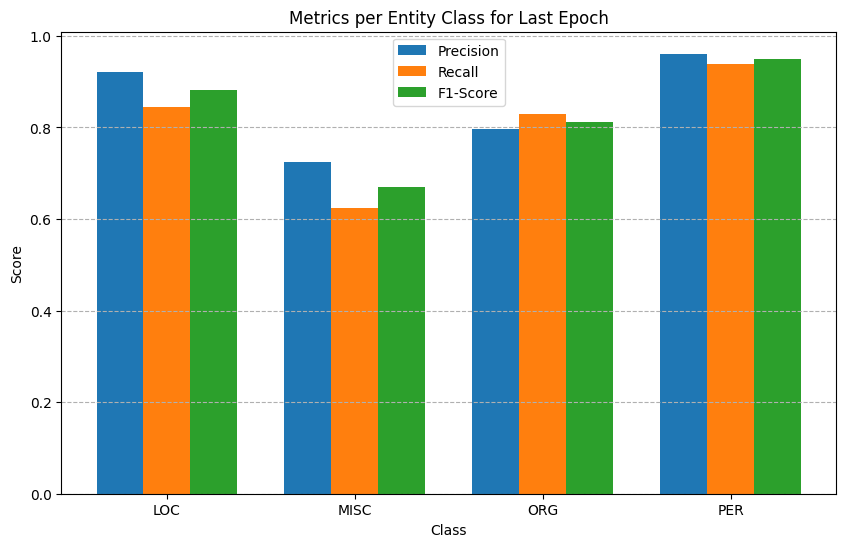

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot classification metrics for the last epoch only
def plot_last_epoch_metrics(detailed_results):
    # Exclude the average keys to focus only on entity-specific results
    categories = [key for key in detailed_results.keys() if key not in ["micro avg", "macro avg", "weighted avg"]]
    precision = [detailed_results[cat]["precision"] for cat in categories]
    recall = [detailed_results[cat]["recall"] for cat in categories]
    f1_score = [detailed_results[cat]["f1-score"] for cat in categories]

    # Set bar positions and width
    x = np.arange(len(categories))
    bar_width = 0.25

    # Create the grouped bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - bar_width, precision, width=bar_width, label="Precision")
    ax.bar(x, recall, width=bar_width, label="Recall")
    ax.bar(x + bar_width, f1_score, width=bar_width, label="F1-Score")

    # Set labels, title, and legend
    ax.set_xlabel("Class")
    ax.set_ylabel("Score")
    ax.set_title("Metrics per Entity Class for Last Epoch")
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()
    ax.grid(axis='y', linestyle='--')

    # Save the graph as an image
    plt.savefig("last_epoch_classification_metrics.png")
    plt.show()

# Assuming `detailed_results` contains the classification report results for the last epoch
# Replace this call with your actual classification report output
# e.g., `detailed_results = classification_report(all_true_labels, all_predictions, output_dict=True)`

plot_last_epoch_metrics(detailed_results)
